# British Airways Reviews Analysis

Notebook 2: NLP


In [35]:
import re
import nltk
import spacy
import contractions
import pandas as pd
import matplotlib.pyplot as plt
import scattertext as st
import seaborn as sns
from collections import Counter
from IPython.display import display, HTML
from nltk.corpus import stopwords
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from sklearn.feature_extraction.text import TfidfVectorizer
from wordcloud import WordCloud

# NLTK will need these for tokenization, part-of-speech tagging,
# sentiment analysis, and named entity recognition.
nltk.download("punkt")
nltk.download("averaged_perceptron_tagger")
nltk.download("stopwords")
nltk.download("vader_lexicon")

[nltk_data] Downloading package punkt to /Users/justn/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/justn/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package stopwords to /Users/justn/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/justn/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

In [36]:
df = pd.read_csv("../data/airline_reviews_clean.csv")

# Remove rows with missing review text
df = df.dropna(subset=["review_text"])

# Remove generic title presumably added as placeholder to untitled reviews
df["title"] = df["title"].str.replace("British Airways customer review", "")

In [37]:
df.head()

,rating,title,country,aircraft,type_of_traveller,seat_type,seat_comfort,cabin_staff_service,food_beverages,inflight_entertainment,...,review_date_month,review_date_year,date_flown_month,date_flown_year,verified,review_text,route_from,route_to,route_has_layover,has_review
0,1.0,"""avoid it at all cost!""",Australia,A380,Business,Business Class,1.0,3.0,3.0,2.0,...,8,2024,8.0,2024.0,False,It is embarrassing to have the word “British...,Sydney,London,False,True
1,10.0,“Great customer service from BA”,United Kingdom,A320,Solo Leisure,Business Class,3.0,5.0,4.0,NaN,...,8,2024,8.0,2024.0,True,"Flight cancelled due to bad weather, BA contac...",Dublin,London Heathrow,False,True
2,1.0,"""Absolute worst travel experience""",United States,Unknown,Couple Leisure,Economy Class,1.0,1.0,NaN,NaN,...,7,2024,7.0,2024.0,True,British Airways oversold my LHR to LAX flight...,London,Los Angeles,True,True
3,3.0,"""one of the worst airlines""",United Kingdom,Unknown,Business,Business Class,5.0,1.0,3.0,3.0,...,7,2024,7.0,2024.0,True,"I travelled London to Doha on July 16th, I ha...",London Heathrow,Doha,False,True
4,1.0,"""my travel pram confiscated from me""",United Kingdom,Unknown,Family Leisure,Economy Class,1.0,1.0,1.0,NaN,...,7,2024,7.0,2024.0,True,When dropping off my luggage at the luggage d...,Toulouse,London Heathrow,False,True


## Feature Extraction


In [38]:
def calculate_text_statistics(df):
    """
    Adds the following columns to the DataFrame:
    - word_count: Number of words in review
    - char_count: Number of characters in review
    - sentence_count: Number of sentences in review
    - avg_word_length: Average length of words in review
    - avg_sentence_length: Average number of words per sentence in review

    Args:
    df (DataFrame): Input DataFrame containing review text

    Returns:
    DataFrame: DataFrame with added columns
    """
    df["word_count"] = df["review_text"].apply(lambda x: len(x.split()))
    df["char_count"] = df["review_text"].apply(len)
    df["sentence_count"] = df["review_text"].apply(lambda x: len(re.split(r"[.!?]", x)))
    df["avg_word_length"] = df.apply(
        lambda row: row["char_count"] / row["word_count"] if row["word_count"] > 0 else pd.NA, axis=1
    )
    df["avg_sentence_length"] = df.apply(
        lambda row: row["word_count"] / row["sentence_count"] if row["sentence_count"] > 0 else pd.NA, axis=1
    )
    return df


df = calculate_text_statistics(df)

# Summary statistics for the new columns
df[["word_count", "char_count", "sentence_count", "avg_word_length", "avg_sentence_length"]].describe()

,word_count,char_count,sentence_count,avg_word_length,avg_sentence_length
count,2304.000000,2304.000000,2304.000000,2304.000000,2304.000000
mean,168.029948,924.348090,11.444878,5.557933,14.425050
std,114.398119,617.027771,6.436874,0.311336,4.969604
min,23.000000,130.000000,2.000000,4.677083,3.250000
25%,87.750000,488.000000,7.000000,5.346648,11.000000
50%,138.000000,766.500000,10.000000,5.531915,13.833333
75%,212.000000,1175.250000,14.000000,5.723474,17.142857
max,654.000000,3517.000000,55.000000,7.428571,52.750000


## Sentiment analysis


In [39]:
def analyze_sentiment(df):
    """
    Perform sentiment analysis on the review text using VADER sentiment analyzer.

    Adds a 'review_sentiment' column to the DataFrame, containing the
    compound sentiment score for each review. The score is standardized to range
    between -1 and +1.

    Args:
    df (DataFrame): Input DataFrame containing review text

    Returns:
    DataFrame: DataFrame with added sentiment score column
    """
    sentiment_analyzer = SentimentIntensityAnalyzer()
    df["review_sentiment"] = df["review_text"].apply(lambda x: sentiment_analyzer.polarity_scores(x)["compound"])

    df["review_sentiment_label"] = df["review_sentiment"].apply(
        lambda x: "positive" if x >= 0.05 else "negative" if x <= -0.05 else "neutral"
    )
    return df


df = analyze_sentiment(df)

# Summary statistics of sentiment scores
df["review_sentiment"].describe()

count    2304.000000
mean        0.059568
std         0.790073
min        -0.997400
25%        -0.801700
50%         0.177700
75%         0.903300
max         0.999200
Name: review_sentiment, dtype: float64

## Text processing


In [40]:
def load_airport_data():
    """
    Load airport code data from davidmegginson/ourairports-data.

    This function:
    1. Loads airport data CSV with airport codes and city names
    2. Drops rows with missing airport codes or city names
    3. Sorts by airport code and sets it as the index for faster lookups

    Returns:
    Dictionary: Dictionary mapping airport codes to city names
    """
    airports_df = pd.read_csv("https://raw.githubusercontent.com/davidmegginson/ourairports-data/main/airports.csv")
    airports_df = airports_df.dropna(subset=["iata_code"]).dropna(subset=["municipality"])
    airports_df = airports_df.sort_values(by="iata_code").reset_index(drop=True)
    airports_df = airports_df.set_index("iata_code")
    return airports_df["municipality"].to_dict()


def replace_airport_codes(text, airports_dict):
    """
    Replaces airport codes in the text with city names.

    Args:
    text (str): Input text containing airport codes
    airports_dict (Dictionary): Dictionary with airport codes mapped to city names

    Returns:
    str: Text with airport codes replaced by city names
    """

    def replace_code(match):
        airport_code = match.group(0)
        return airports_dict.get(airport_code.upper(), airport_code)

    return re.sub(r"\b[A-Z]{3}\b", replace_code, text)

In [41]:
def preprocess_text_data(df):
    """
    Preprocessing steps for the review text:

    1. Expand contractions
    2. Replace airport codes with city names
    3. Identifies and extracts location entities mentioned in the reviews
    4. Tokenizes the text and removes stop words
    5. Extracts adjectives and verbs from the text

    Args:
    df (DataFrame): Input DataFrame containing review text

    Returns:
    DataFrame: DataFrame with preprocessed text data
    """
    nlp = spacy.load("en_core_web_sm")
    stop_words = stopwords.words("english")
    airports_dict = load_airport_data()

    # Expand contractions and replace airport codes
    df["review_text"] = df["review_text"].apply(
        lambda x: " ".join([contractions.fix(word) for word in x.split()]) if isinstance(x, str) else ""
    )
    df["review_text"] = df["review_text"].apply(lambda x: replace_airport_codes(x, airports_dict))

    # Extract location entities
    df["review_locations"] = df["review_text"].apply(
        lambda x: [ent.text for ent in nlp(x).ents if ent.label_ == "GPE"]
    )

    # Add domain-specific stop words
    stop_words.extend(["airline", "flight", "ba", "british", "airways"])
    stop_words.extend([str(loc).lower() for loc in df["review_locations"].apply(list).explode().unique().tolist()])

    # Tokenize and clean text
    df["review_text_tokenized"] = df["review_text"].apply(
        lambda x: [token.lemma_ for token in nlp(x) if token.text.lower() not in stop_words and token.is_alpha]
        if x
        else []
    )
    df["review_text_adj_verb"] = df["review_text"].apply(
        lambda x: " ".join([
            token.lemma_
            for token in nlp(x)
            if token.text.lower() not in stop_words and token.is_alpha and token.pos_ in ["ADJ", "ADV"]
        ])
    )
    df["review_text_clean"] = df["review_text_tokenized"].apply(lambda x: " ".join(x))

    return df


df = preprocess_text_data(df)

## Visualizations


### Rating by Word Count

A line plot showing the relationship between rating and word count


Text(0, 0.5, 'Word Count')

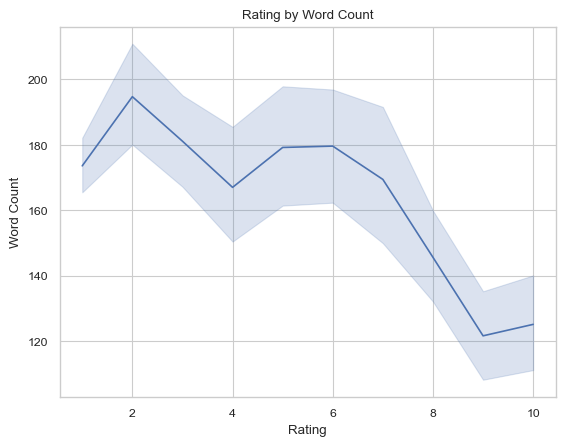

In [57]:
df_temp = df[["rating", "review_sentiment", "recommended", "word_count"]].dropna()
df_temp["recommended"] = df_temp["recommended"].astype("category")

sns.set(style="whitegrid")
sns.set_context("paper")

fig = sns.lineplot(x=df_temp["rating"], y=df_temp["word_count"])
fig.set_title("Rating by Word Count")
fig.set_xlabel("Rating")
fig.set_ylabel("Word Count")

### Rating by Sentiment

Box plots showing the distribution of sentiment scores for each rating


Text(0, 0.5, 'Review Sentiment')

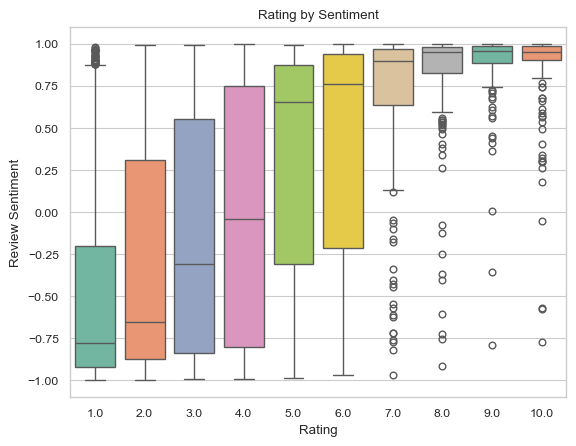

In [58]:
fig = sns.boxplot(
    x=df_temp["rating"], y=df_temp["review_sentiment"], palette="Set2", hue=df_temp["rating"], legend=False
)
fig.set_title("Rating by Sentiment")
fig.set_xlabel("Rating")
fig.set_ylabel("Review Sentiment")

### Rating Distribution by Recommended

A histogram showing the distribution of ratings, split by whether the airline was recommended


Text(0, 0.5, 'Count')

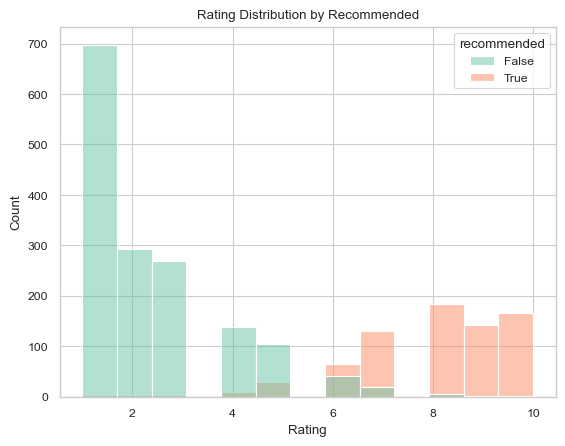

In [59]:
fig = sns.histplot(x=df_temp["rating"], palette="Set2", hue=df_temp["recommended"])
fig.set_title("Rating Distribution by Recommended")
fig.set_xlabel("Rating")
fig.set_ylabel("Count")

### Sentiment Word Clouds with TF-IDF

Identifies the most prominent words in the reviews.


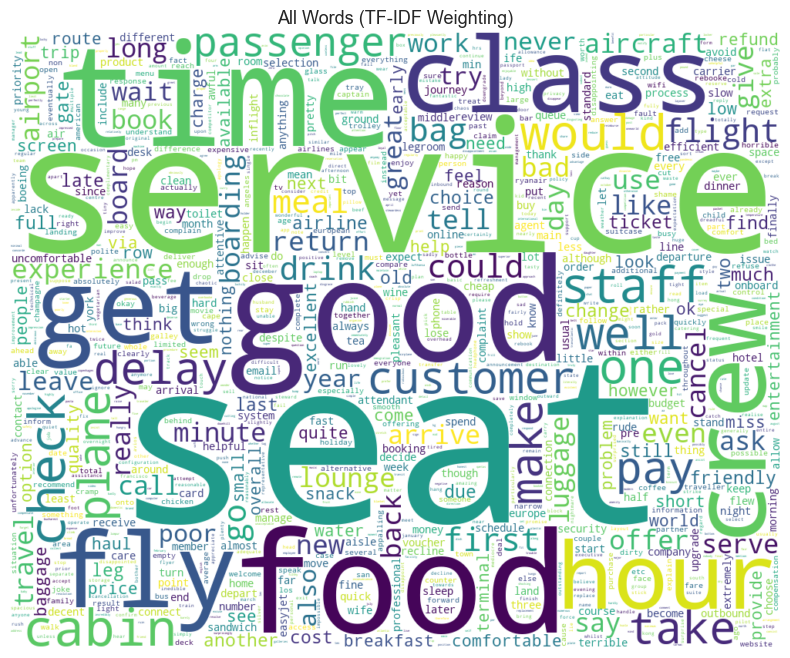

In [60]:
tfidf_vectorizer = TfidfVectorizer()

tfidf_matrix = tfidf_vectorizer.fit_transform(df["review_text_clean"].tolist())

tfidf_weights = [(word, tfidf_matrix.getcol(score).sum()) for word, score in tfidf_vectorizer.vocabulary_.items()]
wordcloud = WordCloud(width=1000, height=800, mode="RGBA", background_color="white", max_words=1000).fit_words(
    dict(tfidf_weights)
)
plt.figure(figsize=(10, 8))
plt.imshow(wordcloud, interpolation="bilinear")
plt.title("All Words (TF-IDF Weighting)", fontsize=13)
plt.axis("off")
plt.show()

### Scattertext Plot


In [61]:
nlp = spacy.load("en_core_web_sm")

corpus = (
    st.CorpusFromPandas(df, category_col="review_sentiment_label", text_col="review_text", nlp=nlp)
    .build()
    .remove_terms(nlp.Defaults.stop_words, ignore_absences=True)
)
scattertext_html = st.produce_scattertext_explorer(
    corpus,
    category="negative",
    category_name="negative",
    not_category_name="positive",
    width_in_pixels=1000,
)

with open("../viz/scattertext.html", "w") as f:
    f.write(scattertext_html)

To view the plot, open `../viz/scattertext.html` in browser.


In [62]:
df.head()

,rating,title,country,aircraft,type_of_traveller,seat_type,seat_comfort,cabin_staff_service,food_beverages,inflight_entertainment,...,char_count,sentence_count,avg_word_length,avg_sentence_length,review_sentiment,review_sentiment_label,review_locations,review_text_tokenized,review_text_adj_verb,review_text_clean
0,1.0,"""avoid it at all cost!""",Australia,A380,Business,Business Class,1.0,3.0,3.0,2.0,...,840,10,5.675676,14.800000,-0.4525,negative,"[Singapore, London]","[embarrassing, word, attach, service, substand...",embarrassing substandard possible technical re...,embarrassing word attach service substandard e...
1,10.0,“Great customer service from BA”,United Kingdom,A320,Solo Leisure,Business Class,3.0,5.0,4.0,NaN,...,356,8,5.933333,7.500000,0.1779,positive,[BA],"[cancel, due, bad, weather, contact, email, im...",bad immediately alternative well different con...,cancel due bad weather contact email immediate...
2,1.0,"""Absolute worst travel experience""",United States,Unknown,Couple Leisure,Economy Class,1.0,1.0,NaN,NaN,...,1494,17,5.595506,15.705882,-0.9737,negative,"[London, Los Angeles, London, Paris, Paris, Pa...","[oversell, Los, Angeles, book, month, advance,...",full actually extra online unknown early manua...,oversell Los Angeles book month advance pay fu...
3,3.0,"""one of the worst airlines""",United Kingdom,Unknown,Business,Business Class,5.0,1.0,3.0,3.0,...,3317,21,5.190923,30.428571,-0.7840,negative,"[London, Doha, Doha, Qatar, Qatar, Qatar, Qata...","[travel, July, physically, check, ongoing, con...",physically ongoing online elsewhere basically ...,travel July physically check ongoing connectio...
4,1.0,"""my travel pram confiscated from me""",United Kingdom,Unknown,Family Leisure,Economy Class,1.0,1.0,1.0,NaN,...,2407,18,5.396861,24.777778,-0.4473,negative,[London],"[drop, luggage, luggage, drop, airport, travel...",old alone old oversized specifically early pre...,drop luggage luggage drop airport travel pram ...


In [63]:
df.to_csv("../data/airline_reviews_clean.csv", index=False)